In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
; kfttを読み込むための自作ライブラリ
(load "../../examples/kftt-data-parser.lisp")
(ql:quickload `(:clgplot :cl-waffe) :silent t)

T

T

(:CLGPLOT :CL-WAFFE)

SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER::REGISTER-WORD
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-DATA-SIZE
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-MAX-LENGTH


Unable to find framework CUDA


## Seq2Seqを用いてKFTTを学習

cl-waffeのRNNを用いて[京都フリー翻訳タスク (KFTT)](http://www.phontron.com/kftt/index-ja.html#leaders)を学習させる例です。

学習データのダウンロード (0.4GB程度の容量が必要です。)
```shell
$ curl -O http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
$ tar xzvf kftt-data-1.0.tar.gz
```

In [2]:
(defpackage :seq2seq-kftt
    (:use :cl :cl-waffe :cl-waffe.nn :clgplot :mgl-mat :kftt-data-parser))

(in-package :seq2seq-kftt)

#<PACKAGE "SEQ2SEQ-KFTT">

#<PACKAGE "SEQ2SEQ-KFTT">

### Seq2Seq

Seq2Seq

問題：

### Seq2Seqモデルを定義する。

In [3]:
(defmodel Encoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1)))
  :forward ((x)
            (with-calling-layers x
                (embedding x)
                (layer x))))

(defmodel Decoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1))
               (h2l       (linearlayer hidden-size vocab-size)))
  :forward ((encoder-state y)
            (let* ((ye (call (self embedding) y))
                   (hs (call (self layer) ye encoder-state))
                   (h-output (call (self h2l) hs)))
                  (list h-output hs))))

(defmodel Seq2Seq (vocab-size-lang1 vocab-size-lang2 embedding-dim input-size)
  :parameters ((encoder (Encoder vocab-size-lang1 embedding-dim input-size))
               (decoder (Decoder vocab-size-lang2 embedding-dim input-size)))  
  :forward ((x y)
            (let ((x-state (call (self encoder) x))
                  (y1 (!zeros (!shape y))))
                 (setq y1 (setf (!aref y1 t) (!aref y '(1 t))))
                 (call (self decoder) x-state y1))))


NIL

NIL

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: undefined type: SEQ2SEQ-KFTT::ENCODER
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::DECODE

### パラメーターの設定

In [4]:
(defparameter lang1 :ja)
(defparameter lang2 :en)

(defparameter batch-size 16)
(defparameter epoch-num 2)
(defparameter lr 1e-4)
(defparameter embedding-dim 16)
(defparameter hidden-size 32)

(defparameter sentence-maxlen 16)
; ja -> en

LANG1

LANG2

BATCH-SIZE

EPOCH-NUM

LR

EMBEDDING-DIM

HIDDEN-SIZE

SENTENCE-MAXLEN

In [5]:
(deftrainer Seq2SeqTrainer (vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :model (Seq2Seq vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :optimizer cl-waffe.optimizers:Adam
  :optimizer-args (:lr lr)
  :step-model ((x y)
               (zero-grad)
               (let* ((outs (call (self model) x y))
                      (out (softmax-cross-entropy (car outs) y)))
                     (backward out)
                     (update)
                     out))
  :predict ((x y) (call (model) x y))) ; todo

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::SEQ2SEQTRAINER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.


### データの前処理

語彙数削減のためSentencePieceを用いる（TODO)

文字数でソートしてPaddingのコストを減らす（TODO)

In [6]:
; 辞書データを作る
(multiple-value-bind (lang1-w2i lang1-i2w) (collect-tokens :dev lang1 T)
    (defparameter w2i-lang1 lang1-w2i)
    (defparameter i2w-lang1 lang1-i2w))

(multiple-value-bind (lang2-w2i lang2-i2w) (collect-tokens :dev lang2 T)
    (defparameter w2i-lang2 lang2-w2i)
    (defparameter i2w-lang2 lang2-i2w))

;w2i: Hash Table, 単語(英語+日本語) -> Index, i2w: Index -> 単語

(format nil "Vocab_Size: ~% Lang1: ~a ~% Lang2: ~a" (hash-table-count w2i-lang1) (hash-table-count w2i-lang2))

I2W-LANG1

I2W-LANG2

"Vocab_Size: 
 Lang1: 4519 
 Lang2: 4780"

In [7]:
; 文字列操作のユーティリティ

(defun split (x str)
  (let ((pos (search x str))
        (size (length x)))
    (if pos
      (cons (subseq str 0 pos)
            (split x (subseq str (+ pos size))))
      (list str))))

(defun list-to-tensor (list)
    (const (make-mat (length list) :initial-contents list)))

(defun words-into-idx (words lang)
    "words: 単語のList, (e.g.: 臨済 宗 （ 臨濟 宗 、)... )
     lang : :ja or :en"
    
    (list-to-tensor
     (map 'list #'(lambda (word)
                          (cond
                              ((eql lang lang1)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang1)))
                              ((eql lang lang2)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang2)))
                              (T (error "")))) `("<BOS>" ,@words "<EOS>"))))

(defun make-train-data (language data-type)
    "Language: 言語
     data-type: :train or :test"
    
    (let ((result nil))
         (time (with-open-kftt-file line :tok data-type language
                   (push
                    (words-into-idx (split " " line) language)
                    result)))
         (reverse result)))

(defun dropout-by-sentence-len (tx ty &aux r1 r2)
    "train_X, train_Yで、sentence-maxlen以上のデータセットを削除する"
    (loop for i fixnum upfrom 0 below (length tx)
          unless (or (>= (!size (nth i tx)) sentence-maxlen)
                     (>= (!size (nth i ty)) sentence-maxlen))
          do (progn
                 (push (nth i tx) r1)
                 (push (nth i ty) r2)))
    (values (reverse r1) (reverse r2)))

SPLIT

LIST-TO-TENSOR

WORDS-INTO-IDX

MAKE-TRAIN-DATA

DROPOUT-BY-SENTENCE-LEN

In [8]:
(defparameter train_X (make-train-data lang1 :dev))
(length train_X)

TRAIN_X

1166

Evaluation took:
  0.072 seconds of real time
  0.046378 seconds of total run time (0.041804 user, 0.004574 system)
  63.89% CPU
  119 lambdas converted
  167,464,018 processor cycles
  15,401,760 bytes consed
  


In [9]:
(defparameter train_Y (make-train-data lang2 :dev))

TRAIN_Y

Evaluation took:
  0.035 seconds of real time
  0.024946 seconds of total run time (0.023610 user, 0.001336 system)
  71.43% CPU
  82,265,296 processor cycles
  14,774,976 bytes consed
  


In [10]:
(multiple-value-bind (x y) (dropout-by-sentence-len train_X train_Y)
    (defparameter train_X x)
    (defparameter train_Y y))

(length train_X)

TRAIN_Y

480

In [11]:
(defparameter test_X (make-train-data lang1 :dev))
(defparameter test_Y (make-train-data lang2 :dev))

TEST_X

TEST_Y

Evaluation took:
  0.040 seconds of real time
  0.026336 seconds of total run time (0.024347 user, 0.001989 system)
  65.00% CPU
  94,278,042 processor cycles
  10,381,328 bytes consed
  
Evaluation took:
  0.057 seconds of real time
  0.038740 seconds of total run time (0.030421 user, 0.008319 system)
  68.42% CPU
  132,406,198 processor cycles
  14,788,704 bytes consed
  


In [12]:
(multiple-value-bind (x y) (dropout-by-sentence-len test_X test_Y)
    (defparameter test_X x)
    (defparameter test_Y y))

(length test_X)

TEST_Y

480

### データセットを定義する



In [13]:
(defdataset KFTT-Dataset (x y batch-size)
    :parameters ((x x)
                 (y y)
                 (batch-size batch-size))
    :next ((index)
           "Returns (list X[index:(+ index batch-size)] Y[index:(+ index batch-size)])"
           (let* ((batch-size (self batch-size))
                  (end (min (length (self x)) (+ index (self batch-size))))
                  (x (loop for i fixnum upfrom index below end
                           collect (nth i (self x))))
                  (y (loop for i fixnum upfrom index below end
                           collect (nth i (self y))))
                  (batch-maxlen (max (apply #'max (map 'list #'!size x))
                                     (apply #'max (map 'list #'!size y))))
                  (result-x (!zeros `(,(length x) ,batch-maxlen)))
                  (result-y (!zeros `(,(length y) ,batch-maxlen))))
                 
                 (dotimes (index (1- (the fixnum (length x))))
                     (setf (!aref result-x index `(0 ,(!size (nth index x)))) (nth index x))
                     (setf (!aref result-y index `(0 ,(!size (nth index y)))) (nth index y)))
                 (list result-x result-y)))
    :length (() (length (self x))))

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-KFTT::KFTT-DATASET when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.


In [14]:
(defparameter *train-dataset* (KFTT-Dataset train_x train_y batch-size))
(defparameter *test-dataset*  (KFTT-Dataset test_x test_y batch-size))

(time (dotimes (i 100) (get-dataset *train-dataset* 0)))

*TRAIN-DATASET*

*TEST-DATASET*

NIL

Evaluation took:
  0.082 seconds of real time
  0.057887 seconds of total run time (0.049851 user, 0.008036 system)
  70.73% CPU
  99 lambdas converted
  189,417,444 processor cycles
  13,946,576 bytes consed
  


In [15]:
(defparameter trainer (seq2seqtrainer (hash-table-count w2i-lang1)
                                      (hash-table-count w2i-lang2)
                                      embedding-dim
                                      hidden-size))
trainer

TRAINER

<Trainer: SEQ2SEQTRAINER()>

In [16]:
(sb-profile:reset)
(sb-profile:profile
 cl-waffe:!aref
 cl-waffe:!matmul)

(defparameter *start-time* (get-universal-time))
(defparameter losses nil)
(dotimes (epoch epoch-num)
    (format t "~ath Epoch: [~as]~%" epoch (- (get-universal-time) *start-time*))
    (let ((dataset-size (get-dataset-length *train-dataset*)))
          (loop for batch-num fixnum upfrom 0 below dataset-size by batch-size
                do (let* ((datum (get-dataset *train-dataset* batch-num))
                          (x (car datum))
                          (y (second datum)))
                         (push (data (step-model trainer x y)) losses)
                         (format t "Loss: ~a~%" (car (last losses)))))))
(sb-profile:report)

NIL

*START-TIME*

LOSSES

NIL

(8.457819 8.457807 8.4581785 8.458789 8.458921 8.459221 8.459518 8.460041
 8.460466 8.460215 8.460338 8.461014 8.461284 8.461405 8.46152 8.461809
 8.461968 8.46231 8.462627 8.463125 8.464764 8.464607 8.46372 8.463995 8.464374
 8.464548 8.464721 8.464946 8.46512 8.465269 8.46575 8.465822 8.46608 8.466446
 8.466594 8.466831 8.467046 8.4673605 8.467667 8.467622 8.467761 8.468107
 8.468362 8.468486 8.468645 8.468866 8.469052 8.469279 8.4695 8.469781 8.47042
 8.470477 8.470333 8.470543 8.470795 8.470989 8.471144 8.47133 8.471543
 8.4717045)

0th Epoch: [0s]
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
1th Epoch: [39s]
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
Loss: 8.4717045
measuri

*IMGPATH*

NIL

NIL

0

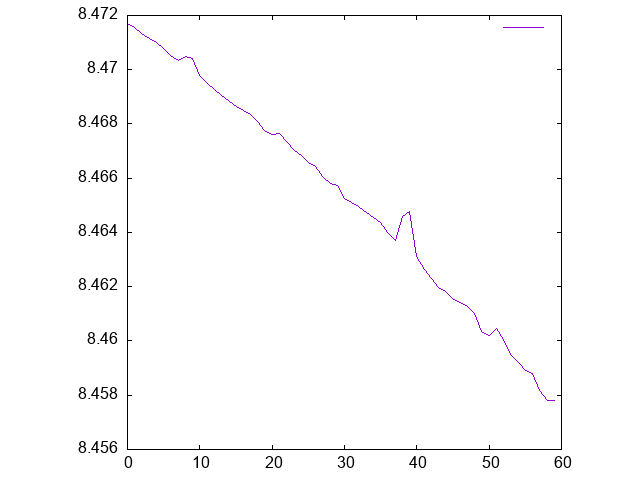

In [19]:
(defparameter *imgpath* "./tmp/Seq2Seq_KFTT_Losses.png")
; pushしてるからLossの向き反対だわ...

(plot (reverse losses) :output *imgpath*)
(jupyter:file *imgpath* :display t)